### Loading GNM output

In [39]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
from scipy.spatial import distance_matrix
from Censored_copula import truncgauss

#################################################################### Loading GNM ####################################################################
model_version = 5
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch
path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
location_keys = list(GNM_output.keys())                 # 'lat_58.95_57.35_lon_-6.55_-4.95', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [float(location_key.split('_')[i]) for i in [1,2,4,5]]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][0][row][column]

location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = GNM_output[location_keys[100]]['date']
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
                continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]])
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([round(temp_lat_lon[0]-0.6-row*0.1,2),round(temp_lat_lon[2]+0.6+col*0.1,2)])
            for param_idx,param in enumerate(output_keys[:-1]):
                for week in range(286):
                    for day in range(7):
                        GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][week][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(4087)]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))
#################################################################### Preparing map ####################################################################
m = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3)
            
m_loc_4087 = [[0,1] for i in range(len(GNM_landonly))]
for i in range(len(GNM_landonly)):
    m_loc_4087[i][0] = m(3,GNM_landonly[i][5][0])[1]
    m_loc_4087[i][1] = m(GNM_landonly[i][5][1],3)[0]
  

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_5/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_5/checkpoints/epoch=11-step=9147-val_loss_loss=-0.391-val_metric_mse_rain=21.686.ckpt']


c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 344/344 [00:25<00:00, 13.31it/s]


### Plotting map vs observed

211


2it [00:03,  1.81s/it]


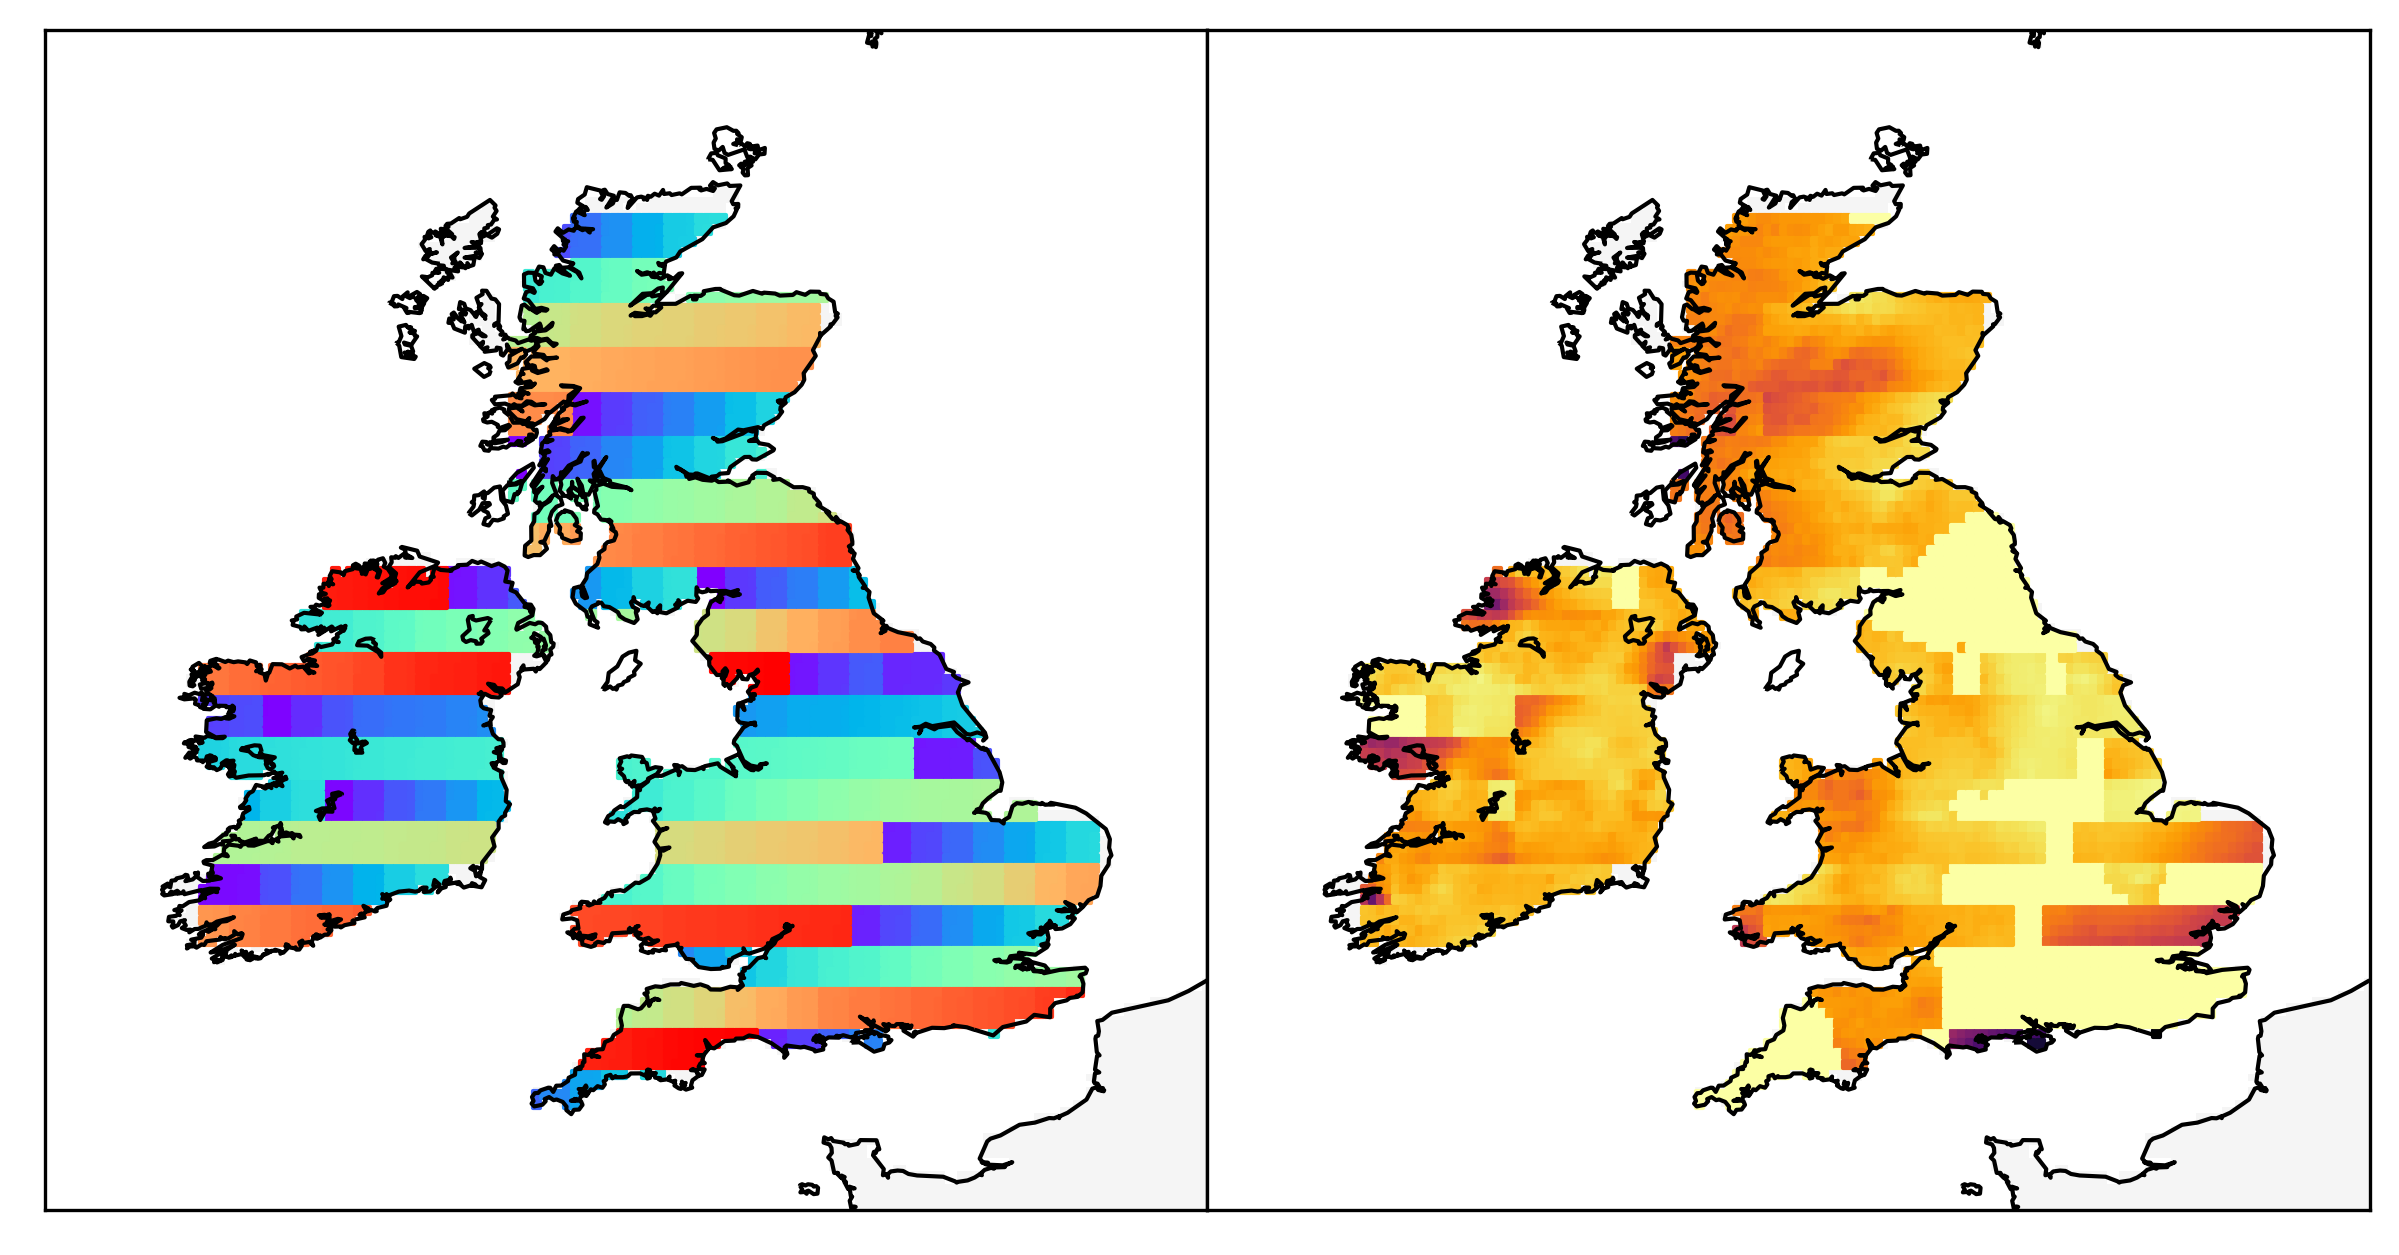

In [90]:
# plot locations plot vs observed rain for range of days
for k in [211]:
    print(k)
    fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True,sharey=True,figsize=(10,7))
    length = len(GNM_landonly)

    for day,ax in tqdm(enumerate(axes.flat)):
        map_ax = Basemap(projection='mill',
                resolution='i',llcrnrlat = 49,
                llcrnrlon = -12,
                urcrnrlat = 60,
                urcrnrlon = 3,
                ax=ax)
        fig.set_dpi(300)
        map_ax.drawcoastlines()
        map_ax.drawlsmask(land_color='whitesmoke')
        ax.set_aspect('equal')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplots_adjust(wspace=0, hspace=0)
        if day==0:
            ax.scatter(x=[m_loc_4087[i][1]for i in range(length)],y=[m_loc_4087[i][0] for i in range(length)],c=[i for i in range(len(GNM_landonly))][:length],cmap='rainbow',s=3,marker='s')
        else:
            ax.scatter(x=[m_loc_4087[i][1] for i in range(length)],y=[m_loc_4087[i][0]for i in range(length)],c=np.array([GNM_landonly[i][3][k] for i in range(length)]),cmap='inferno_r',s=3,marker='s')
    plt.show()

### Simulating

Run this block to simulate. Change values at the top for day, samples, etc... Takes ~40s for all locations

In [140]:
# Run this block to simulate. Change values at the top for day, samples, etc... Takes ~1:30m for all locations.

sim_day = 0
sim_locations = range(4087)
kernel_type = 'Matern'
theta_values = [4.01,3.08]
nb_samples = 3

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define truncation pi on normal scale := di. This is done for the whole dataset, no need to touch.
truncation_di = [[GNM_landonly[loc][4][day] for loc in range(4087)] for day in range(2002)] # di[day][loc]
truncation_di = scs.norm.ppf(np.array(truncation_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_us=truncation_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type)
simulated_rain = [[g_Finv(0,loc,simulated_us[draw][loc]) for loc in range(len(simulated_us[0]))] for draw in range(len(simulated_us))]

print('Simulations done!')

Simulations done!


In [78]:

# get everything ready in this new version in orer to gert simulations, then keep working in here. Make it clean!


### Plotting samples

No need to touch anything, just run cells.

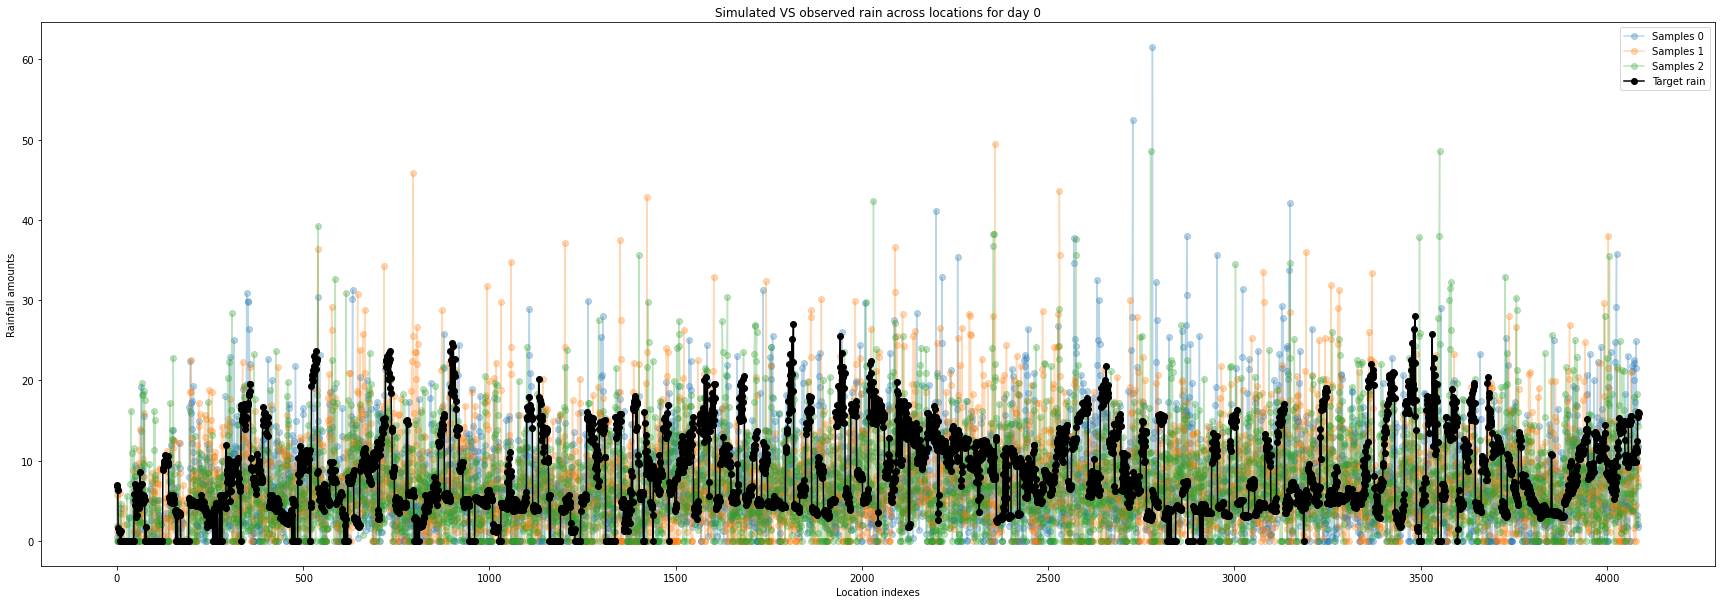

In [141]:
# Samples vs target rain with locations on the x-axis and rain on the y-axis.
fig = plt.gcf()
fig.set_size_inches(30, 10)
dpi=300
for k in range(len(simulated_rain)):
    plt.plot(simulated_rain[k],'-o',alpha=0.3,label='Samples '+str(k))
plt.plot([GNM_landonly[loc][3][sim_day] for loc in sim_locations ],'-o',color='black',label='Target rain')

plt.xlabel('Location indexes')
plt.ylabel('Rainfall amounts')
plt.title('Simulated VS observed rain across locations for day '+str(sim_day))
plt.legend(loc='upper right')
plt.show()

4it [00:06,  1.73s/it]


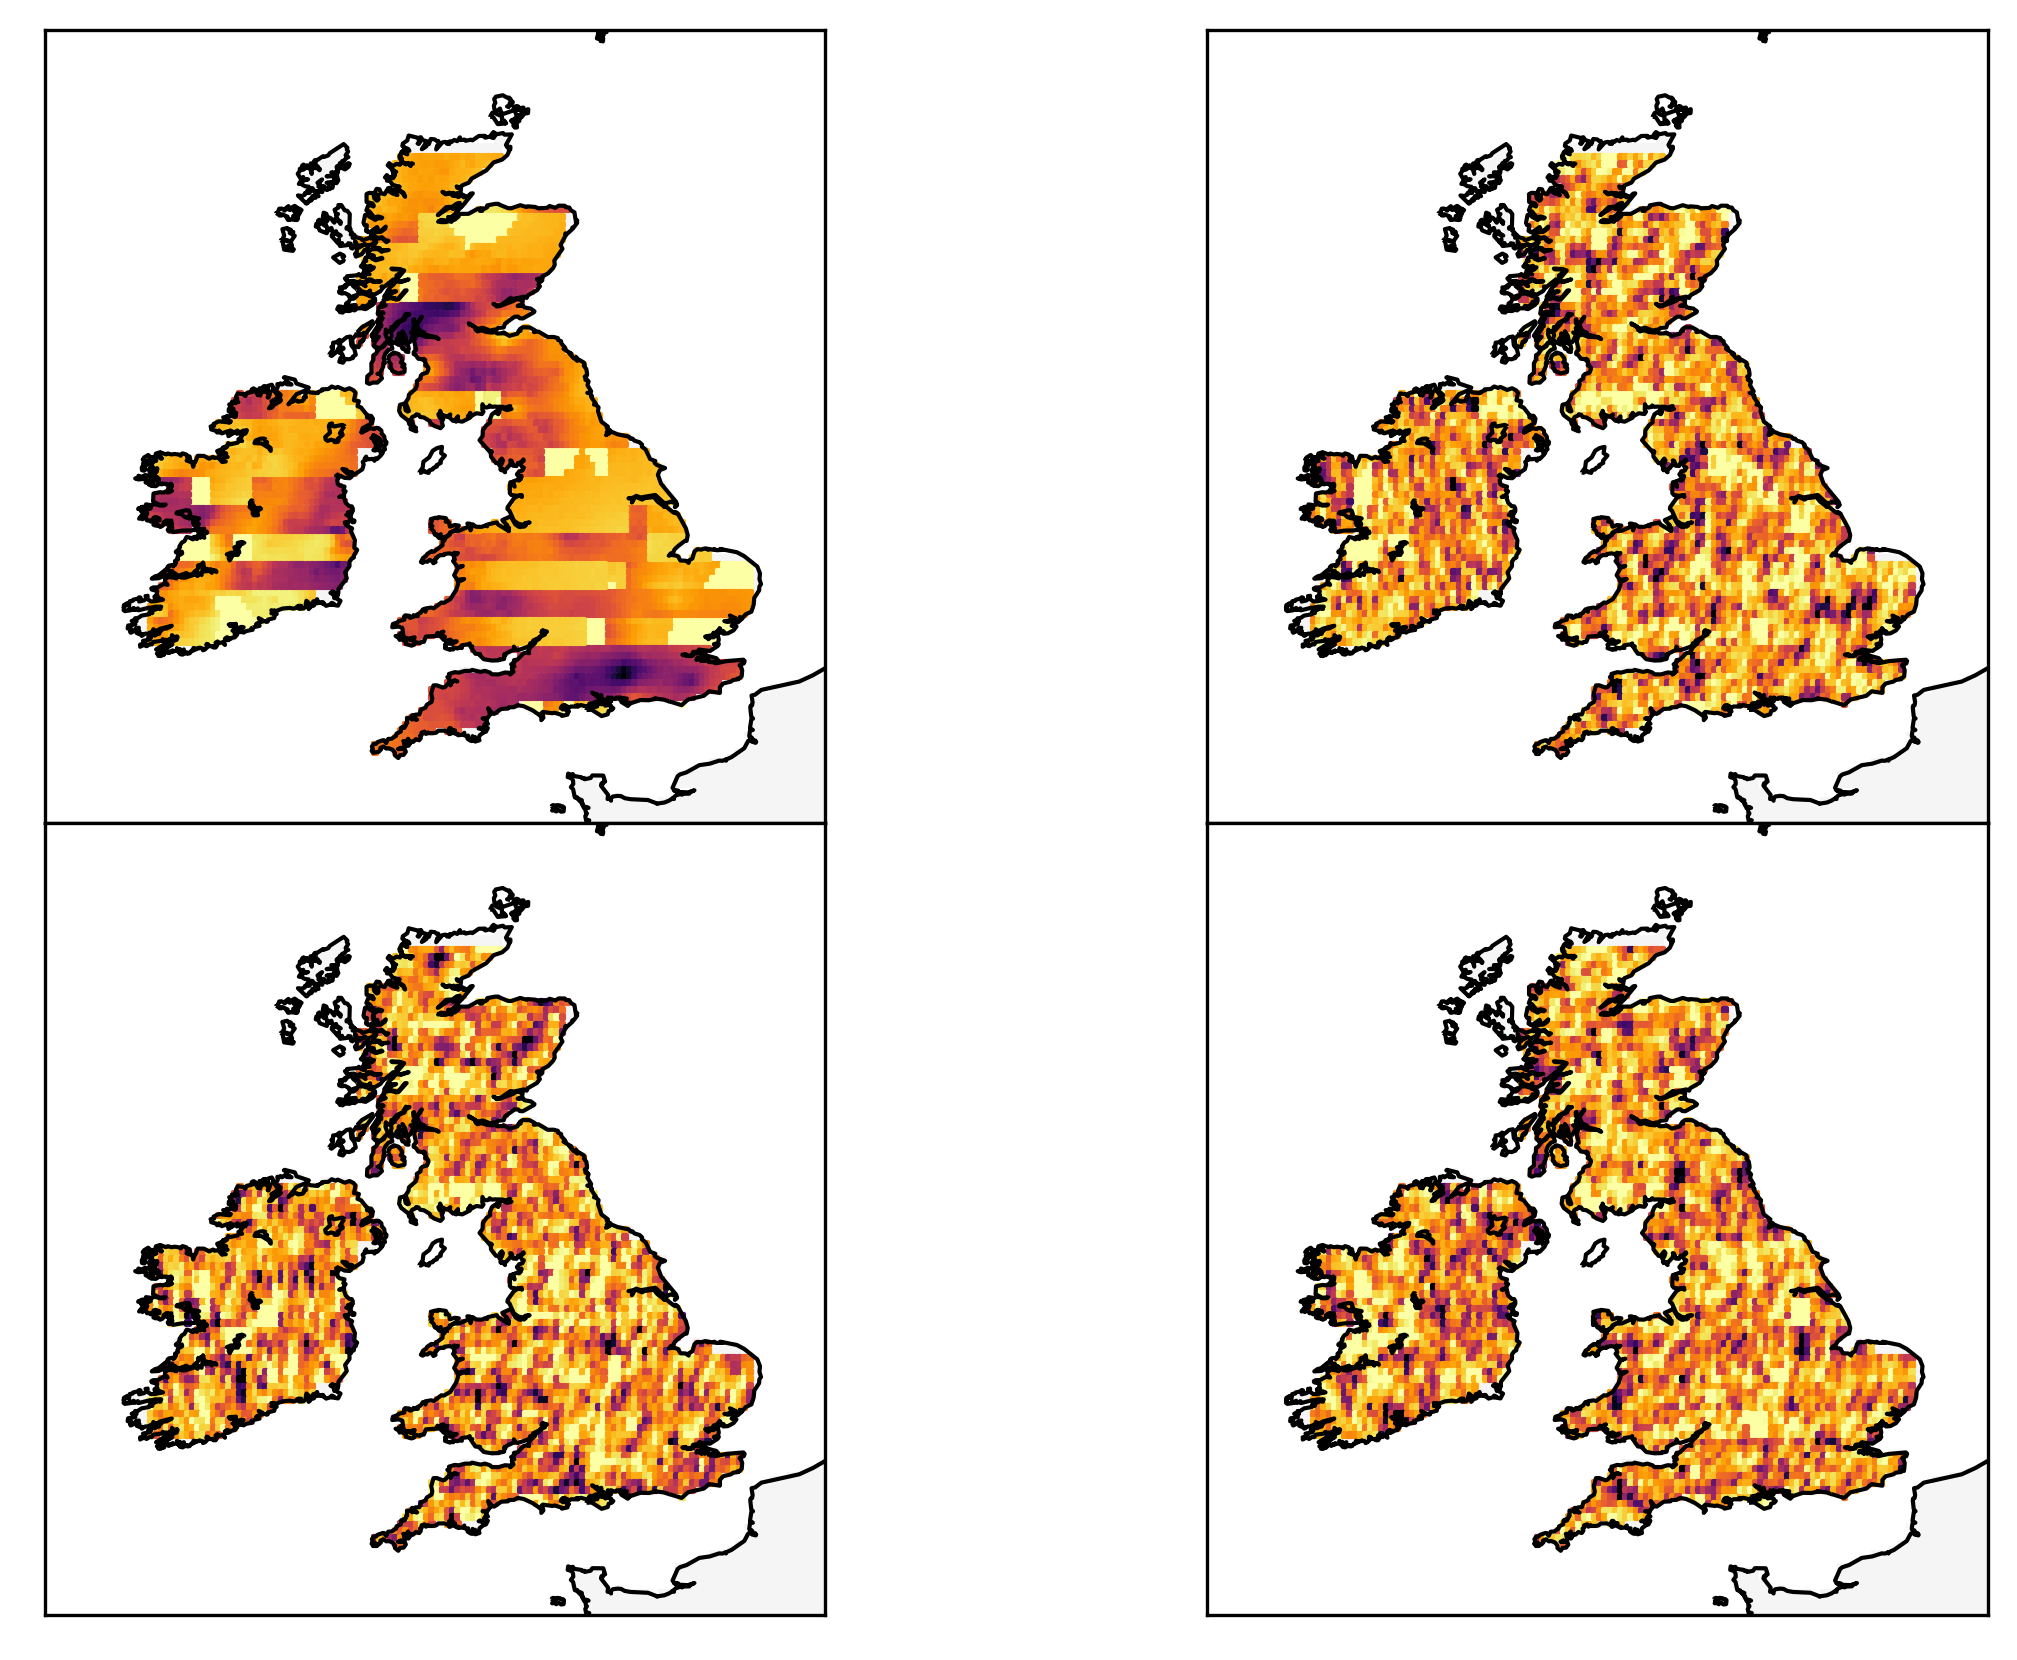

In [142]:
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(10,7))
length = max(sim_locations)
for day,ax in tqdm(enumerate(axes.flat)):
    map_ax = Basemap(projection='mill',
            resolution='i',llcrnrlat = 49,
            llcrnrlon = -12,
            urcrnrlat = 60,
            urcrnrlon = 3,
            ax=ax)
    fig.set_dpi(300)
    map_ax.drawcoastlines()
    map_ax.drawlsmask(land_color='whitesmoke')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    if day==0:
        ax.scatter(x=[m_loc_4087[i][1]for i in range(length)],y=[m_loc_4087[i][0] for i in range(length)],c=[GNM_landonly[loc][3][sim_day] for loc in range(length)],cmap='inferno_r',s=0.8,marker='s')
    else:
        max_rain = max([GNM_landonly[loc][3][sim_day] for loc in range(length)])
        ax.scatter(x=[m_loc_4087[i][1] for i in range(length)],y=[m_loc_4087[i][0]for i in range(length)],c=np.minimum(np.array(simulated_rain[day-1]),np.array([max_rain for l in range(len(simulated_rain[0]))])),cmap='inferno_r',s=0.8,marker='s')
plt.show()

### Notes

Latitude and longitude of locations we predict for and use are increments of 0.1 degrees, with 5 as second decimal values (0.05,0.15,0.25,...) .
